<a href="https://colab.research.google.com/github/alirezash97/BRATS2015/blob/master/results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import cv2
import keras 
import random

Using TensorFlow backend.


In [2]:
from keras import backend as K

def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
  
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))


    return dice_loss


def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean((dice_numerator)/(dice_denominator))
    
 
    return dice_coefficient

In [3]:

# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('/content/drive/My Drive/BRATS2020/FlowerModel.01-0.23.h5', custom_objects={'soft_dice_loss':soft_dice_loss, 'dice_coefficient':dice_coefficient})
# summarize model.
model.summary()
# load dataset

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 80, 16, 4 0                                            
__________________________________________________________________________________________________
conv3d_58 (Conv3D)              (None, 80, 80, 16, 3 3488        input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_72 (Conv3D)              (None, 80, 80, 16, 3 3488        input_2[0][0]                    
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 80, 80, 16, 3 0           conv3d_58[0][0]                  
____________________________________________________________________________________________

In [9]:
import glob, os
images_path = glob.glob('/content/drive/My Drive/BRATS2020/MICCAI_BraTS2020_TrainingData/**/*.nii.gz', recursive=True)

data_path = ""

X_trainset_filenames = []
y_trainset_filenames = []

for item in images_path:
  if 'seg' in item:
    y_trainset_filenames.append(os.path.join(data_path, item))
  else:
    X_trainset_filenames.append(os.path.join(data_path, item))

In [10]:
def load_case(image_nifty_file, label_nifty_file):


    image_nifty_file 
    
    # load the image and label file, get the image content and return a numpy array for each
    image = np.zeros((240, 240, 155, 4))

    img0 = np.array(nib.load(image_nifty_file[0]).get_fdata())
    img1 = np.array(nib.load(image_nifty_file[1]).get_fdata())
    img2 = np.array(nib.load(image_nifty_file[2]).get_fdata())
    img3 = np.array(nib.load(image_nifty_file[3]).get_fdata())
    
    image[:, :, :, 0] = img0
    image[:, :, :, 1] = img1
    image[:, :, :, 2] = img2
    image[:, :, :, 3] = img3
      
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    
    return image, label

In [11]:
def sort_by_channel(sample_path):

  n = int(len(sample_path) / 4)
  new_path = []
  for i in range(n):
    temp = sample_path[(i*4): (i+1)*4]
    new_temp = []

    ###############
    for path in temp:
      if '_t1.' in path:
        new_temp.append(path)
      else:
        pass
    for path in temp:
      if '_t1ce.' in path:
        new_temp.append(path)
      else:
        pass
    for path in temp:
      if '_t2.' in path:
        new_temp.append(path)
      else:
        pass
    for path in temp:
      if '_flair.' in path:
        new_temp.append(path)
      else:
        pass

    ################    
    for path in new_temp:
      new_path.append(path)


  return new_path

In [12]:
X_trainset_filenames_by_channels = sort_by_channel(X_trainset_filenames[26:30])

In [41]:
image , label = load_case(X_trainset_filenames_by_channels, y_trainset_filenames[6])

In [14]:
print(image.shape)
print(label.shape)

(240, 240, 155, 4)
(240, 240, 155)


In [29]:
def get_sub_volume(image, label):
  
  sub_volume_X = []
  sub_volume_y = []

  for j in range (0, 240, 80):
    for k in range(0, 240, 80):
      for z in range(8, 147, 16):
        sub = image[ j:j+80, k:k+80, z:z+16, :]
        sub_volume_X.append(sub)
        sub = label[ j:j+80, k:k+80, z:z+16]
        sub_volume_y.append(sub)



  return sub_volume_X, sub_volume_y





In [39]:
X, y = get_sub_volume(image, label)

In [31]:
print(len(X))
print(len(y))

81
81


In [33]:
print(X[1].shape)
print(y[1].shape)

(80, 80, 16, 4)
(80, 80, 16)


In [38]:
from tqdm import tqdm

y_pred = []
for item in tqdm(X):
  temp_0 = item.reshape((1, 80, 80, 16, 4))
  temp = model.predict(temp_0)
  y_pred.append(temp)


100%|██████████| 81/81 [09:00<00:00,  6.68s/it]


In [42]:
label.shape

(240, 240, 155)

In [55]:
def get_whole_image(predict):
  
  prediction = np.zeros((240, 240, 155, 3))

  counter = 0
  for j in range (0, 240, 80):
    for k in range(0, 240, 80):
      for z in range(8, 147, 16):
        prediction[j:j+80, k:k+80, z:z+16, :] = predict[counter]
        counter +=1



  return prediction

In [56]:
y = get_whole_image(y_pred)
print(y.shape)

(240, 240, 155, 3)


In [62]:
from ipywidgets import interact

def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 3
    plt.imshow(y[:, :, layer, :]);
    plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0, 155 - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

In [53]:
from ipywidgets import interact

def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 3
    plt.imshow(label[:, :, layer]);
    plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0, 155 - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

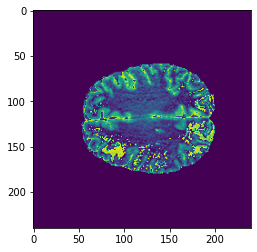

In [ ]:
plt.imshow((img[0, :, :, 100] * 255).astype(np.uint8))

In [ ]:
print(y_predict.shape)

(1, 240, 240, 155)


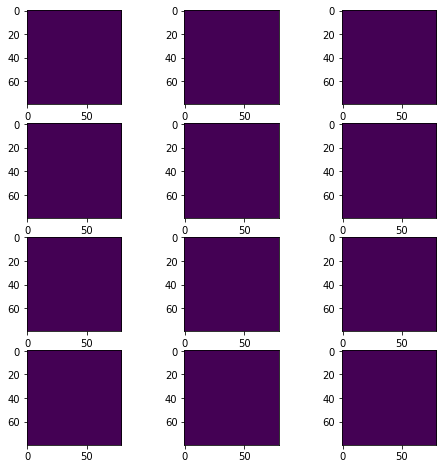

In [ ]:
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 4
for i in range(1, columns*rows +1):
    img = y_pred[0, :, :, i, 2]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

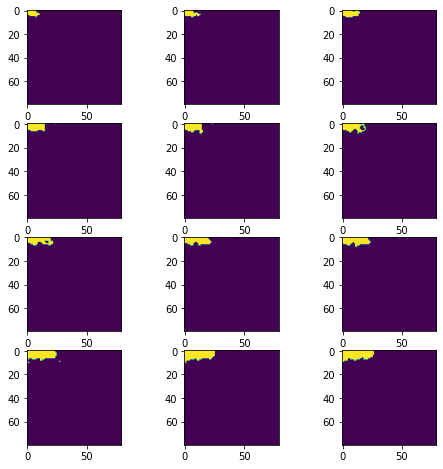

In [ ]:
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 4
for i in range(1, columns*rows +1):
    img = y[0, :, :, i]
    fig.add_subplot(rows, columns, i)
    plt.imshow((img * 255).astype(np.uint8))
plt.show()